In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [3]:
df = pd.read_csv('../20200120_Test06.csv')

In [15]:
df.columns

Index(['Unnamed: 0', 'UTM Disp', 'UTM Force', 'TA1-1-1', 'TA1-1-2', 'TA1-1-3',
       'TA1-2-1', 'TA1-2-2', 'TA1-2-3', 'TA1-3-1', 'TA1-3-2', 'TA1-3-3',
       'TA2-1-1', 'TA2-1-2', 'TA2-1-3', 'TA2-2-1', 'TA2-2-2', 'TA2-2-3',
       'TA2-3-1', 'TA2-3-2', 'TA2-3-3', 'C1', 'C2', 'C3', 'LVDT Lower',
       'LVDT Upper'],
      dtype='object')

In [ ]:
# for i in range(0, len(df), 1000):
#     optimal_num = i
#     plt.figure(figsize=(12, 6))
#     plt.plot(df['UTM Disp'][:i], df['UTM Force'][:i], color = 'k')
#     plt.ylabel('Force', fontsize = 15)
#     plt.xlabel('Displacement', fontsize = 15)
#     plt.savefig(f'./plot/plot_{i}.png')
#     plt.close()

In [364]:
from pathlib import Path
from PIL import Image
import re


In [367]:
def _natural_key(s: str):
    import re
    return [int(t) if t.isdigit() else t.lower() for t in re.findall(r'\d+|\D+', s)]

def make_gif_slow_tail(
    folder,
    output_gif,
    pattern="*.png",
    start_fps=12,        # 시작 프레임 속도(빠르게)
    end_fps=4,           # 끝 프레임 속도(느리게)
    timing='ease_out',   # 'linear'|'ease_in'|'ease_out'|'ease_in_out' 또는 callable
    resize=None,         # (W,H)
    reverse=False,       # 왕복
    loop=0,              # 0=무한반복
    background=None,     # (255,255,255) 등 지정시 투명→배경색 합성
    optimize=True,
    disposal=2
):
    folder = Path(folder)
    files = sorted(folder.glob(pattern), key=lambda p: _natural_key(p.name))
    if not files:
        raise FileNotFoundError(f"No files matched {pattern} in {folder}")

    # 이징 함수들
    def ease(x):
        if callable(timing):
            return timing(x)
        if timing == 'linear':
            return x
        if timing == 'ease_in':
            return x * x
        if timing == 'ease_out':
            return 1 - (1 - x) ** 2
        if timing == 'ease_in_out':
            return 0.5 * (1 - (1 - 2*x) ** 3) if x < 0.5 else 0.5 + 0.5 * ((2*x - 1) ** 3)
        return x  # fallback

    # 프레임 로드
    frames = []
    base_size = None
    for i, p in enumerate(files):
        im = Image.open(p).convert("RGBA")
        if background is not None:
            bg = Image.new("RGBA", im.size, background + (255,))
            im = Image.alpha_composite(bg, im)
        if i == 0:
            base_size = resize if resize else im.size
        if resize:
            im = im.resize(base_size, resample=Image.LANCZOS)
        elif im.size != base_size:
            canvas = Image.new("RGBA", base_size, (0,0,0,0))
            canvas.paste(im, (0,0))
            im = canvas
        frames.append(im.convert("P", palette=Image.ADAPTIVE, colors=256))

    # 프레임별 duration 생성 (ms). 뒤로 갈수록 커지게!
    # 너무 작은 duration은 일부 뷰어에서 최소 20ms로 클램핑됨에 유의.
    n = len(frames)
    start_ms = int(round(1000 / max(start_fps, 1)))
    end_ms   = int(round(1000 / max(end_fps,   1)))
    if n == 1:
        durations = [end_ms]
    else:
        durations = [
            int(round(start_ms + (end_ms - start_ms) * ease(i / (n - 1))))
            for i in range(n)
        ]

    if reverse:
        frames = frames + list(reversed(frames))
        durations = durations + list(reversed(durations))

    frames[0].save(
        output_gif,
        save_all=True,
        append_images=frames[1:],
        duration=durations,   # <- 리스트로 넣어 프레임마다 다르게
        loop=loop,
        optimize=optimize,
        disposal=disposal,
    )
    print(f"Saved GIF: {output_gif}  ({len(frames)} frames, {base_size[0]}x{base_size[1]})")


In [370]:
make_gif_slow_tail("./plot", "out.gif", start_fps=16, end_fps=8, resize=(800,600), background=(255,255,255))

Saved GIF: out.gif  (93 frames, 800x600)


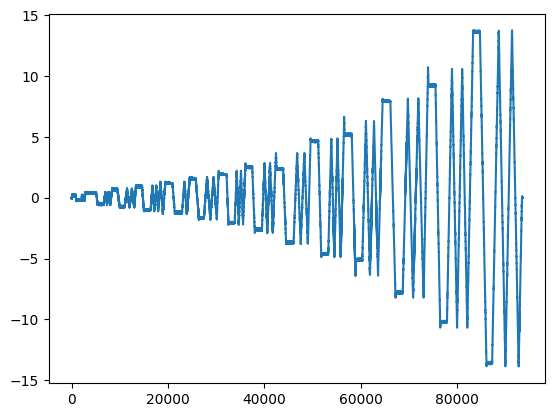

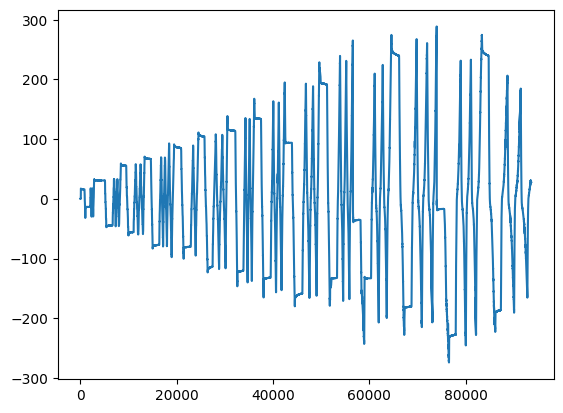

In [31]:
plt.plot(df['UTM Disp'])
plt.show()
plt.plot(df['UTM Force'])
plt.show()

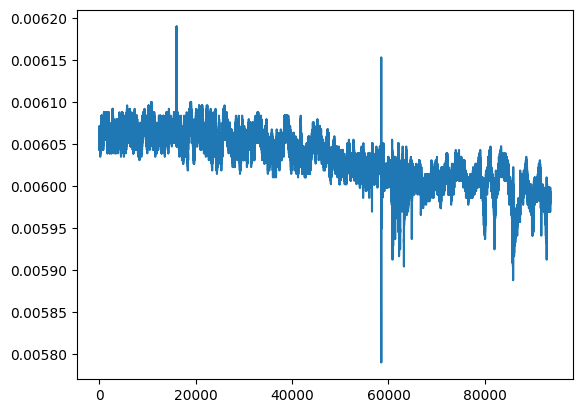

In [211]:
plt.plot(df['TA2-1-3'])

In [143]:
def _update_z(z_i, v_i, A, beta, gamma, n, dt):
    """
    z_{i+1} = z_i + dt * A * ( v_i - beta*|v_i|*|z|^(n-1)*z - gamma*v_i*|z|^n )
    """
    abs_z = abs(z_i)
    if abs_z < 1e-12:
        z_pow_n = 0.0
        z_pow_n_minus_1_z = 0.0
    else:
        z_pow_n = abs_z ** n
        # |z|^(n-1)*z = sign(z) * |z|^n = (z/|z|) * |z|^n
        z_pow_n_minus_1_z = (z_i / abs_z) * z_pow_n

    dzdt = A * (v_i - beta * abs(v_i) * z_pow_n_minus_1_z - gamma * v_i * z_pow_n)
    return z_i + dt * dzdt

In [144]:
def simulate_disp_control(u, a, k, A, beta, gamma, n, dt=1.0, z0=0.0):
    u = np.asarray(u, dtype=float)
    N = len(u)
    z = np.zeros(N, dtype=float)
    F = np.zeros(N, dtype=float)

    z[0] = z0
    F[0] = a * k * u[0] + (1 - a) * k * z[0]

    for i in range(N - 1):
        v = (u[i + 1] - u[i]) / dt
        z[i + 1] = _update_z(z[i], v, A, beta, gamma, n, dt)
        F[i + 1] = a * k * u[i + 1] + (1 - a) * k * z[i + 1]

    return F, z

In [145]:
def simulate_force_control(F, a, k, A, beta, gamma, n, dt=1.0, z0=0.0, u0=0.0, eps=1e-12):
    F = np.asarray(F, dtype=float)
    N = len(F)
    u = np.zeros(N, dtype=float)
    z = np.zeros(N, dtype=float)

    u[0] = u0
    z[0] = z0

    ak = max(a * k, eps)  # 수치 안정
    for i in range(N - 1):
        # explicit: F_{i+1}로 u_{i+1} 계산
        u_next = (F[i + 1] - (1 - a) * k * z[i]) / ak
        v = (u_next - u[i]) / dt
        z[i + 1] = _update_z(z[i], v, A, beta, gamma, n, dt)
        u[i + 1] = u_next

    return u, z

In [146]:
def huber_loss(residuals, delta=1.0):
    """Mean Huber loss."""
    r = np.abs(residuals)
    q = np.minimum(r, delta)
    lin = r - q
    return np.mean(0.5 * q**2 + delta * lin)

def safe_r2(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    num = np.sum((y_true - y_pred) ** 2)
    den = np.sum((y_true - np.mean(y_true)) ** 2)
    if den <= 1e-20:
        return np.nan
    return 1.0 - num / den

In [147]:
def _vec_to_params(theta):
    """
    theta = [k_e, k_p, A, beta, gamma, n]
    returns dict with a, k, A, beta, gamma, n
    """
    k_e, k_p, A, beta, gamma, n = theta
    k_sum = max(k_e + k_p, 1e-12)
    a = k_e / k_sum
    k = k_sum
    return dict(a=a, k=k, A=A, beta=beta, gamma=gamma, n=n)

In [187]:
def fit_bouc_wen_parameters_bidir(
    displacement=None,
    force=None,
    mode='disp',          # 'disp' : u -> F,  'force' : F -> u
    dt=1.0,
    n_starts=15,
    seed=None,
    huber_delta=1.0,
    lam_smooth=0.0,       # only effective in 'force' mode (smooth u)
    method='L-BFGS-B',
    verbose=True
):
    """
    Bidirectional identification of Bouc-Wen parameters.
    Returns: dict(params, loss, r2, success, mode)
    """

    assert mode in ('disp', 'force'), "mode must be 'disp' or 'force'"
    rng = np.random.default_rng(seed)

    if mode == 'disp':
        assert displacement is not None and force is not None, "Need displacement & force for 'disp' mode"
        u = np.asarray(displacement, dtype=float)
        F_target = np.asarray(force, dtype=float)
        N = min(len(u), len(F_target))
        u = u[:N]
        F_target = F_target[:N]
        # Rough stiffness scale
        disp_range = np.max(u) - np.min(u) if N > 0 else 1.0
        force_range = np.max(F_target) - np.min(F_target) if N > 0 else 1.0
        k0 = force_range / max(disp_range, 1e-9)
    else:
        assert displacement is not None and force is not None, "Need force & displacement target for 'force' mode"
        # Here 'displacement' is the target, and 'force' is input
        u_target = np.asarray(displacement, dtype=float)
        F_in = np.asarray(force, dtype=float)
        N = min(len(u_target), len(F_in))
        u_target = u_target[:N]
        F_in = F_in[:N]
        disp_range = np.max(u_target) - np.min(u_target) if N > 0 else 1.0
        force_range = np.max(F_in) - np.min(F_in) if N > 0 else 1.0
        k0 = force_range / max(disp_range, 1e-9)

    # Initial guess & bounds in transformed space (k_e, k_p, A, beta, gamma, n)
    # k_e, k_p >= kmin to avoid degeneracy
    kmin = max(k0 * 1e-3, 1e-6)
    kmax = max(k0 * 1e3, 1.0) if k0 > 0 else 1e3
    A_min, A_max = 1e-3, 10.0
    beta_min, beta_max = -2.0, 2.0
    gamma_min, gamma_max = -2.0, 2.0
    n_min, n_max = 1.0, 8.0

    base_init = np.array([
        0.7 * k0,  # k_e
        0.3 * k0,  # k_p
        0.5,       # A
        0.1,       # beta
        0.1,       # gamma
        2.0        # n
    ], dtype=float)

    bounds = [
        (kmin, kmax),     # k_e
        (kmin, kmax),     # k_p
        (A_min, A_max),   # A
        (beta_min, beta_max),   # beta
        (gamma_min, gamma_max), # gamma
        (n_min, n_max)    # n
    ]

    def make_init():
        jitter = rng.normal(0.0, 0.25, size=6)  # 25% Gaussian jitter
        guess = base_init * (1.0 + jitter)
        # clip into bounds
        clipped = np.array([
            np.clip(guess[0], bounds[0][0], bounds[0][1]),
            np.clip(guess[1], bounds[1][0], bounds[1][1]),
            np.clip(guess[2], bounds[2][0], bounds[2][1]),
            np.clip(guess[3], bounds[3][0], bounds[3][1]),
            np.clip(guess[4], bounds[4][0], bounds[4][1]),
            np.clip(guess[5], bounds[5][0], bounds[5][1]),
        ])
        return clipped

    def objective(theta):
        pars = _vec_to_params(theta)
        try:
            if mode == 'disp':
                F_pred, _ = simulate_disp_control(
                    u, pars['a'], pars['k'], pars['A'], pars['beta'], pars['gamma'], pars['n'], dt=dt
                )
                res = F_pred - F_target
                loss_data = huber_loss(res, delta=huber_delta)
                return loss_data

            else:  # 'force'
                u_pred, _ = simulate_force_control(
                    F_in, pars['a'], pars['k'], pars['A'], pars['beta'], pars['gamma'], pars['n'], dt=dt, u0=u_target[0]
                )
                res = u_pred - u_target
                loss_data = huber_loss(res, delta=huber_delta)
                # smoothness regularization on u (discourages jitter in inverse)
                if lam_smooth > 0 and len(u_pred) > 2:
                    du = np.diff(u_pred)
                    loss_smooth = np.mean(du**2) / max(dt**2, 1e-12)
                else:
                    loss_smooth = 0.0
                return loss_data + lam_smooth * loss_smooth

        except FloatingPointError:
            return 1e10
        except Exception:
            return 1e10

    best = None
    best_fun = np.inf
    best_res = None

    methods = [method]  # allow easy extension
    for m in methods:
        for s in range(n_starts):
            x0 = make_init()
            try:
                res = minimize(objective, x0, method=m, bounds=bounds, options={'maxiter': 400, 'disp': False})
                if res.success and res.fun < best_fun:
                    best_fun = res.fun
                    best = res.x
                    best_res = res
                    if verbose:
                        print(f"[{mode}] {m} start#{s+1:02d}: loss={res.fun:.6e} ✓")
                else:
                    if verbose:
                        print(f"[{mode}] {m} start#{s+1:02d}: loss={res.fun:.6e}")
            except Exception as e:
                if verbose:
                    print(f"[{mode}] {m} start#{s+1:02d}: failed ({e})")

    if best is None:
        # fallback to base init
        best = base_init
        success = False
    else:
        success = bool(best_res.success)

    params = _vec_to_params(best)

    # Report R^2 on chosen mode
    if mode == 'disp':
        F_pred, _ = simulate_disp_control(u, **params, dt=dt)
        r2 = safe_r2(F_target, F_pred)
    else:
        u_pred, _ = simulate_force_control(F_in, **params, dt=dt, u0=u_target[0])
        r2 = safe_r2(u_target, u_pred)

    out = dict(
        a=params['a'], k_i=params['k'], A=params['A'], beta=params['beta'], gamma=params['gamma'], n=params['n'],
        loss=float(best_fun), r2=float(r2) if r2 == r2 else np.nan, success=success, mode=mode
    )
    return out

In [188]:
def validate_model_assumption(displacement, force, fitted_params, dt=1.0):
    """
    Validate in displacement-controlled assumption (u -> F).
    """
    u = np.asarray(displacement, dtype=float)
    F_true = np.asarray(force, dtype=float)
    N = min(len(u), len(F_true))
    u, F_true = u[:N], F_true[:N]

    F_sim, z_sim = simulate_disp_control(
        u,
        fitted_params['a'], fitted_params['k_i'],
        fitted_params['A'], fitted_params['beta'],
        fitted_params['gamma'], fitted_params['n'],
        dt=dt
    )

    err = F_sim - F_true
    mae = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    r2 = safe_r2(F_true, F_sim)

    print("\n" + "="*50)
    print("변위 제어 모델 검증")
    print("="*50)
    print(f"  MAE : {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²  : {r2 if r2==r2 else float('nan'):.6f}")
    print(f"  최적화 성공: {fitted_params.get('success', None)}")
    print("\n물리 파라미터:")
    print(f"  a={fitted_params['a']:.6f}, k={fitted_params['k_i']:.6f}, A={fitted_params['A']:.6f}, "
          f"beta={fitted_params['beta']:.6f}, gamma={fitted_params['gamma']:.6f}, n={fitted_params['n']:.6f}")
    print(f"\n히스테리시스 z: range={np.max(z_sim)-np.min(z_sim):.6f}, mean|z|={np.mean(np.abs(z_sim)):.6f}")

    return dict(
        mae=mae, rmse=rmse, r2=r2,
        simulation_results=dict(force=F_sim, displacement=u, hysteresis_variable=z_sim)
    )

In [189]:
def compare_bouc_wen_results(original_disp, original_force, simulation_results):
    """
    Draws hysteresis loop, force/time, z/time, error/time.
    Accepts results from validate_model_assumption() or manual simulate_*().
    """
    if 'simulation_results' in simulation_results:
        sim = simulation_results['simulation_results']
        force_sim = sim['force']
        disp_sim = sim['displacement']
        z_sim = sim['hysteresis_variable']
    else:
        force_sim = simulation_results['force']
        disp_sim = simulation_results['displacement']
        z_sim = simulation_results['hysteresis_variable']

    original_disp = np.asarray(original_disp, dtype=float)
    original_force = np.asarray(original_force, dtype=float)

    N = min(len(original_disp), len(original_force), len(force_sim), len(disp_sim), len(z_sim))
    original_disp = original_disp[:N]
    original_force = original_force[:N]
    force_sim = force_sim[:N]
    disp_sim = disp_sim[:N]
    z_sim = z_sim[:N]

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1) hysteresis
    axes[0, 0].plot(original_disp, original_force, '-', alpha=0.7, linewidth=1, label='Original')
    axes[0, 0].plot(disp_sim, force_sim, '--', linewidth=2, label='Bouc-Wen')
    axes[0, 0].set_xlabel('Displacement')
    axes[0, 0].set_ylabel('Force')
    axes[0, 0].set_title('Hysteresis Loop')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2) force vs time
    t = np.arange(N)
    axes[0, 1].plot(t, original_force, '-', alpha=0.7, linewidth=1, label='Original')
    axes[0, 1].plot(t, force_sim, '--', linewidth=2, label='Bouc-Wen')
    axes[0, 1].set_xlabel('Time Steps')
    axes[0, 1].set_ylabel('Force')
    axes[0, 1].set_title('Force vs Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3) z
    axes[1, 0].plot(t, z_sim, '-', linewidth=2)
    axes[1, 0].set_xlabel('Time Steps')
    axes[1, 0].set_ylabel('Hysteresis Variable (z)')
    axes[1, 0].set_title('z Evolution')
    axes[1, 0].grid(True, alpha=0.3)

    # 4) error
    err = original_force - force_sim
    axes[1, 1].plot(t, err, linewidth=1)
    axes[1, 1].set_xlabel('Time Steps')
    axes[1, 1].set_ylabel('Force Error')
    axes[1, 1].set_title('Force Prediction Error')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    mae = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    max_error = float(np.max(np.abs(err)))

    print("Bouc-Wen 모델 정확도:")
    print(f"  MAE : {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  Max : {max_error:.6f}")

    return dict(mae=mae, rmse=rmse, max_error=max_error)

In [190]:
def simulate_bouc_wen(displacement_input, fitted_params, dt=1.0):
    """(u -> F) 시뮬레이션"""
    F_sim, z_sim = simulate_disp_control(
        displacement_input,
        fitted_params['a'], fitted_params['k_i'],
        fitted_params['A'], fitted_params['beta'],
        fitted_params['gamma'], fitted_params['n'],
        dt=dt
    )
    return dict(displacement=np.asarray(displacement_input, dtype=float),
                force=F_sim, hysteresis_variable=z_sim, parameters=fitted_params)

def validate_force_control(force_input, disp_target, fitted_params, dt=1.0, lam_smooth=0.0):
    """(F -> u) 검증"""
    u_pred, z_pred = simulate_force_control(
        force_input,
        fitted_params['a'], fitted_params['k_i'],
        fitted_params['A'], fitted_params['beta'],
        fitted_params['gamma'], fitted_params['n'],
        dt=dt,
        u0=float(disp_target[0])
    )
    err = u_pred - np.asarray(disp_target, dtype=float)
    mae = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    r2 = safe_r2(disp_target, u_pred)
    print("\n" + "="*50)
    print("힘 제어 모델 검증")
    print("="*50)
    print(f"  MAE : {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²  : {r2 if r2==r2 else float('nan'):.6f}")
    return dict(mae=mae, rmse=rmse, r2=r2,
                simulation_results=dict(displacement=u_pred, force=np.asarray(force_input, float), hysteresis_variable=z_pred))


In [371]:
optimal_num = len(df) #

In [372]:
params_disp = fit_bouc_wen_parameters_bidir(
    displacement=df['UTM Disp'][:optimal_num], force=df['UTM Force'][:optimal_num], mode='disp', dt=0.1,
    n_starts=10, seed=42, huber_delta=0.5, lam_smooth=0.0, verbose=False
)

In [389]:
# plt.figure(figsize=(12, 6))
# plt.plot(val_disp['simulation_results']['force'], label = 'Simulation', alpha = 0.7)

# plt.plot(df['UTM Force'], label = 'Actual')
# plt.legend()
# plt.show()


변위 제어 모델 검증
  MAE : 55.896442
  RMSE: 68.231327
  R²  : 0.629901
  최적화 성공: False

물리 파라미터:
  a=0.700000, k=20.363090, A=0.500000, beta=0.100000, gamma=0.100000, n=2.000000

히스테리시스 z: range=4.224251, mean|z|=0.824285


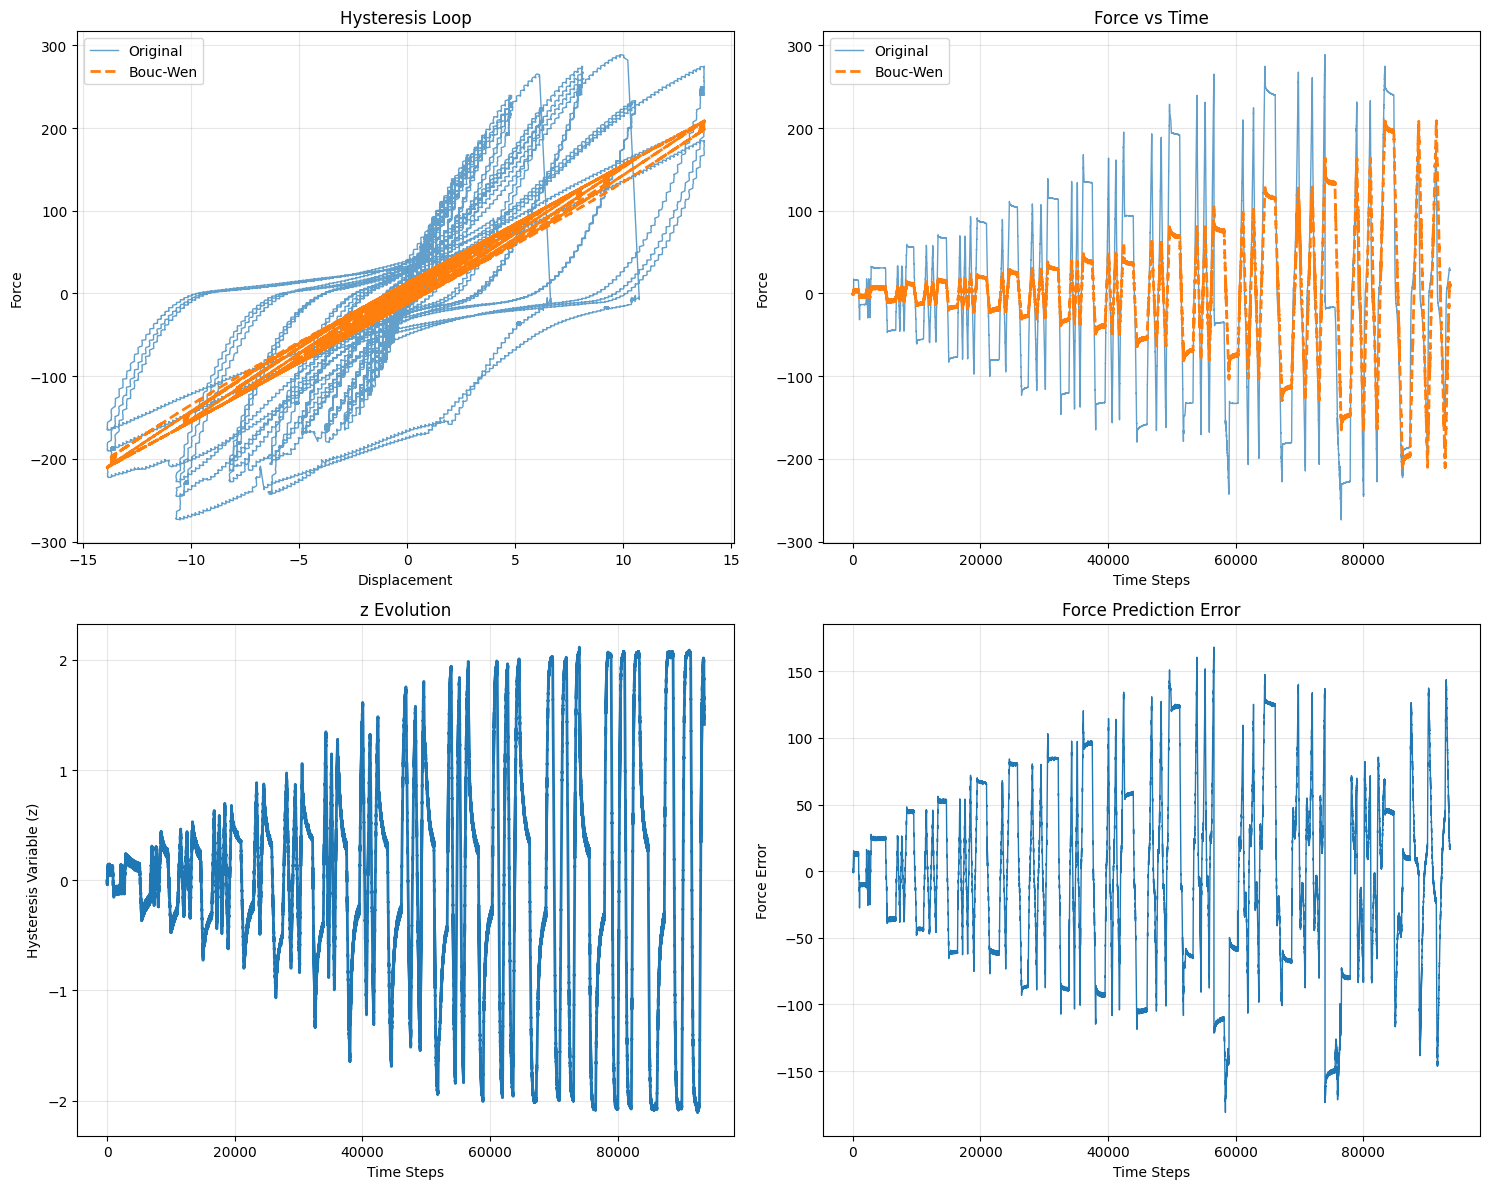

Bouc-Wen 모델 정확도:
  MAE : 55.896442
  RMSE: 68.231327
  Max : 180.974546


{'mae': 55.896442439907815,
 'rmse': 68.2313269640848,
 'max_error': 180.97454643896629}

In [373]:
val_disp = validate_model_assumption(df['UTM Disp'][:optimal_num], df['UTM Force'][:optimal_num], params_disp, dt=0.1)
compare_bouc_wen_results(df['UTM Disp'][:optimal_num], df['UTM Force'][:optimal_num], val_disp)


변위 제어 모델 검증
  MAE : 55.896442
  RMSE: 68.231327
  R²  : 0.629901
  최적화 성공: False

물리 파라미터:
  a=0.700000, k=20.363090, A=0.500000, beta=0.100000, gamma=0.100000, n=2.000000

히스테리시스 z: range=4.224251, mean|z|=0.824285


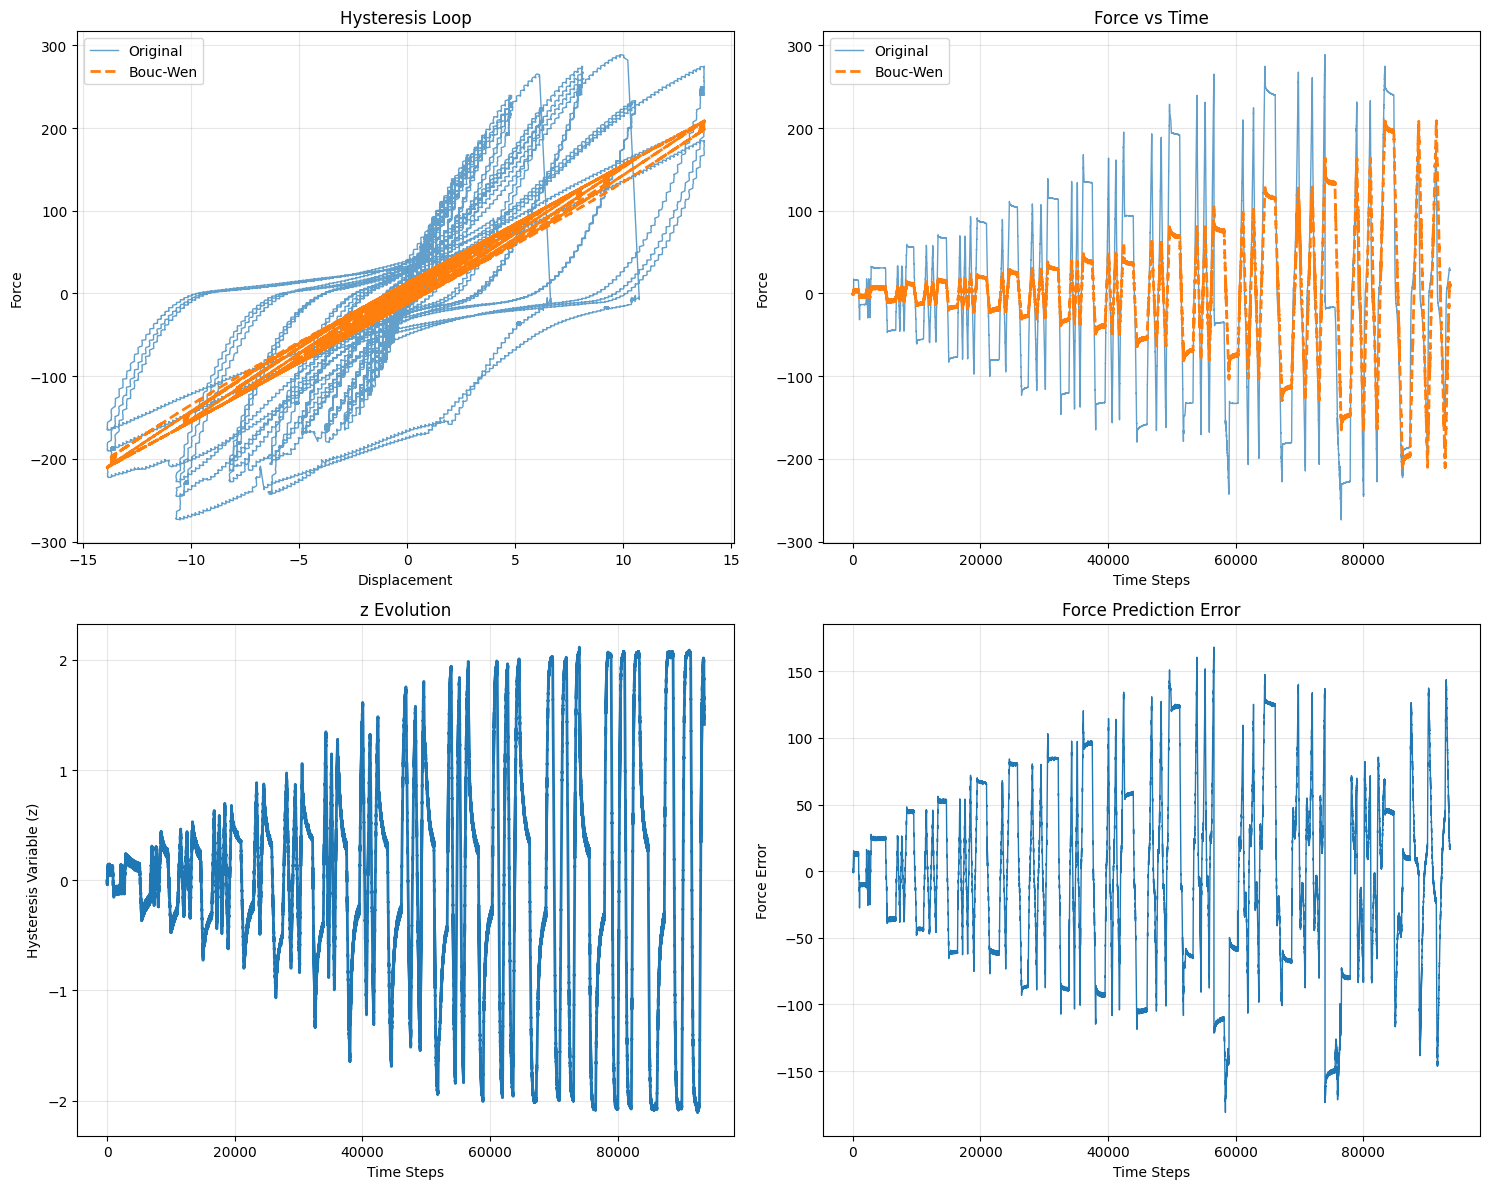

Bouc-Wen 모델 정확도:
  MAE : 55.896442
  RMSE: 68.231327
  Max : 180.974546


{'mae': 55.896442439907815,
 'rmse': 68.2313269640848,
 'max_error': 180.97454643896629}

In [393]:
params = fit_bouc_wen_parameters_bidir(
    displacement=df['UTM Disp'].values[:optimal_num],
    force=df['UTM Force'].values[:optimal_num],
    mode='force',
    dt=0.1,
    n_starts=10, seed=0, huber_delta=0.5, verbose=False, lam_smooth=0
)
val = validate_model_assumption(df['UTM Disp'].values[:optimal_num], df['UTM Force'].values[:optimal_num], params, dt=0.1)
compare_bouc_wen_results(df['UTM Disp'][:optimal_num], df['UTM Force'][:optimal_num], val)


In [259]:
# params_inv = fit_bouc_wen_parameters_bidir(
#     displacement=df['UTM Disp'].values[:optimal_num],  # 타깃 변위
#     force=df['UTM Force'].values[:optimal_num],        # 입력 힘
#     mode='force',
#     dt=0.1,
#     n_starts=20, seed=0, huber_delta=0.5, lam_smooth=1e-4
# )
# val_inv = validate_force_control(df['UTM Force'].values[:optimal_num], df['UTM Disp'].values[:optimal_num], params_inv, dt=0.1)


In [470]:
def fit_by_chunks(df, n_chunks=10, **kwargs):
    N = len(df)
    edges = np.linspace(0, N, n_chunks + 1, dtype=int)
    out = {}
    for j in tqdm(range(n_chunks)):
        s, e = edges[j], edges[j+1]
        if e - s < kwargs.get('min_points', 0):  # 최소 길이 확인
            continue
        out[(s, e)] = fit_bouc_wen_parameters_bidir(
            displacement=df['UTM Disp'].values[s:e],
            force=df['UTM Force'].values[s:e], verbose=False,
            **{k:v for k,v in kwargs.items() if k in {
                'mode','dt','n_starts','seed','huber_delta','lam_smooth','verbose'
            }}
        )
    return out

In [478]:
params_dict2 = fit_by_chunks(df, n_chunks=500, mode='disp', dt=0.1,
                             n_starts=15, seed=42, huber_delta=0.5)

100%|██████████| 500/500 [06:19<00:00,  1.32it/s]


In [479]:
def params_dict_to_df(params_dict, dt=0.1):
    """
    params_dict: {(start_idx, end_idx): {'a','k_i','A','beta','gamma','n','r2','loss',...}}
    반환: 각 윈도우의 대표 시간(mid_time)과 파라미터를 담은 DataFrame (mid_time 기준 정렬)
    """
    rows = []
    for (s, e), p in sorted(params_dict.items(), key=lambda x: x[0][0]):
        row = {
            'start_idx': s,
            'end_idx': e,
            'mid_idx': (s + e) / 2,
            'start_time': s * dt,
            'end_time': e * dt,
            'mid_time': ((s + e) / 2) * dt
        }
        # 파라미터 복사
        for k, v in p.items():
            row[k] = v
        # 파생 파라미터
        if 'a' in p and 'k_i' in p:
            row['k_e'] = p['a'] * p['k_i']          # elastic part
            row['k_p'] = (1 - p['a']) * p['k_i']    # hysteretic part
        rows.append(row)
    dfp = pd.DataFrame(rows).sort_values('mid_time').reset_index(drop=True)
    return dfp

In [480]:
params_df = params_dict_to_df(params_dict2)

In [481]:
params_df.columns

Index(['start_idx', 'end_idx', 'mid_idx', 'start_time', 'end_time', 'mid_time',
       'a', 'k_i', 'A', 'beta', 'gamma', 'n', 'loss', 'r2', 'success', 'mode',
       'k_e', 'k_p'],
      dtype='object')

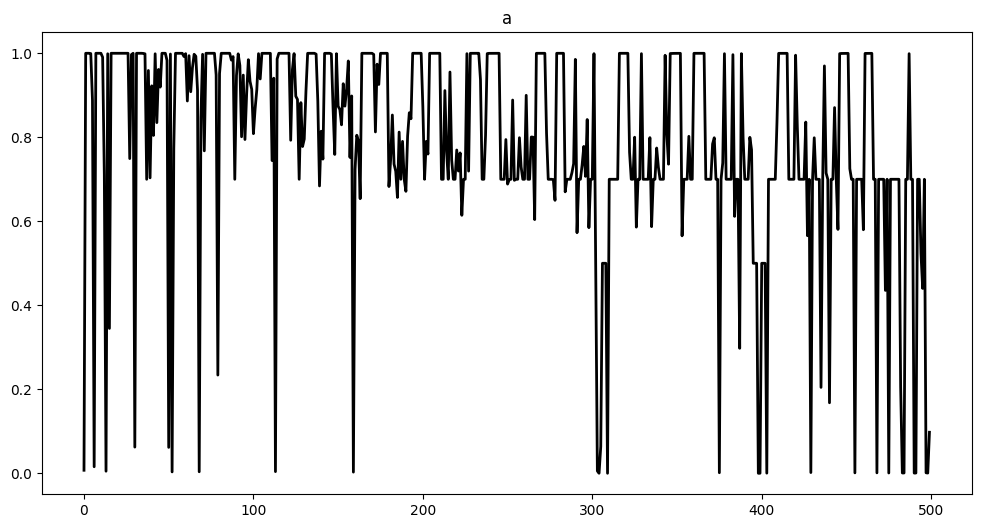

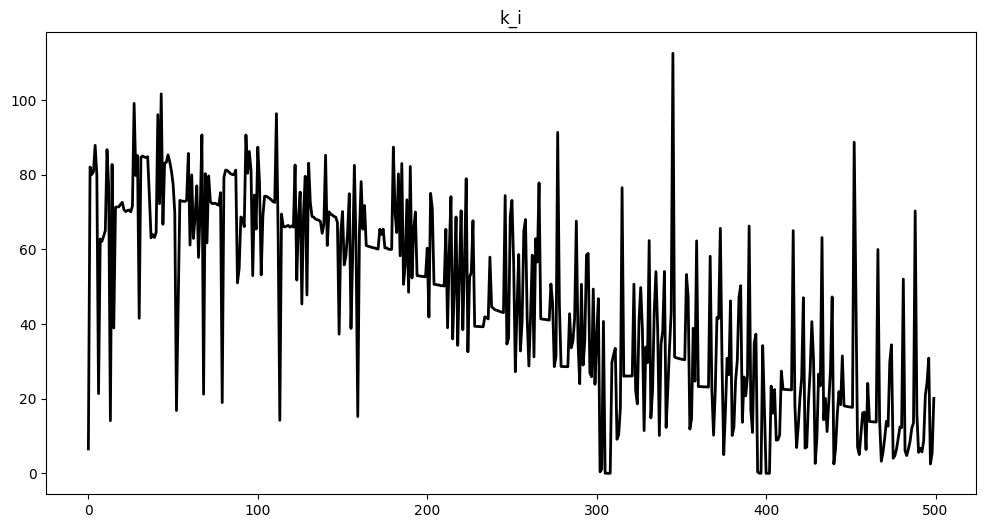

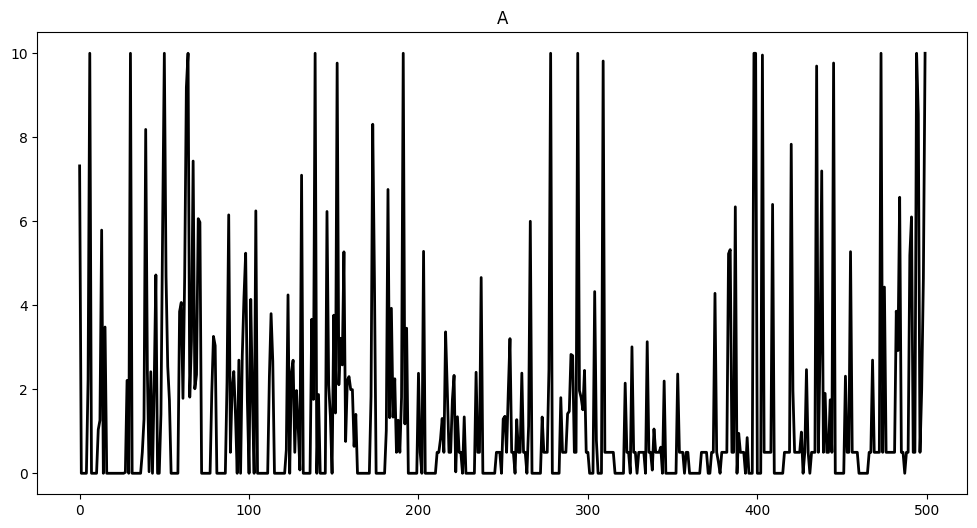

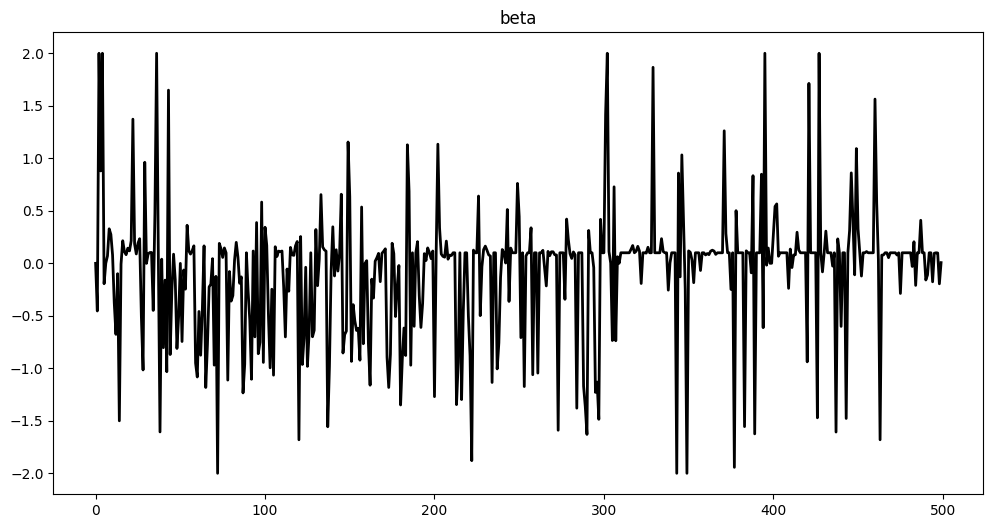

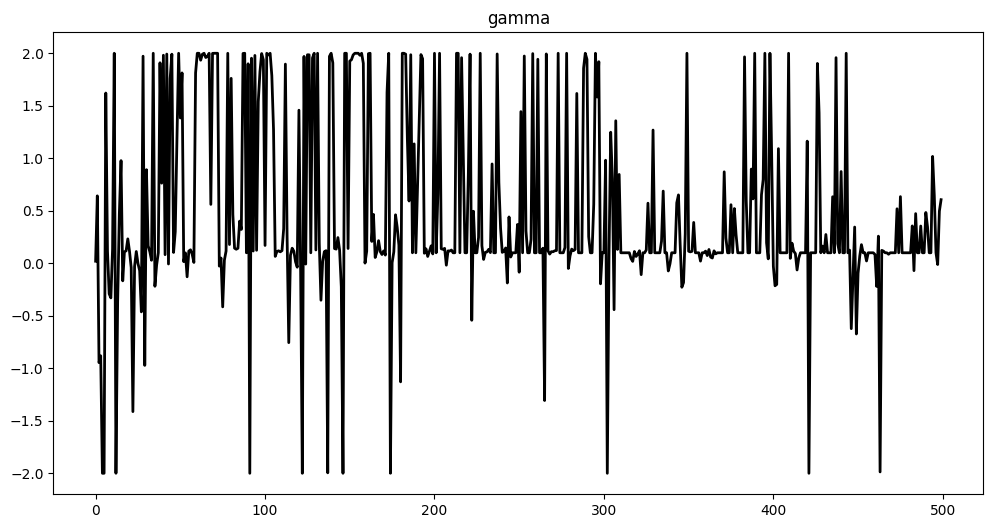

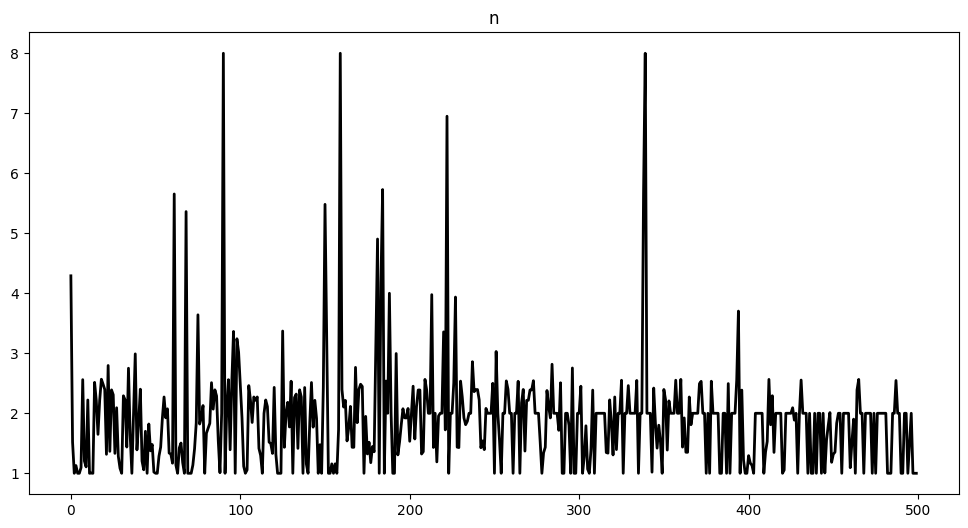

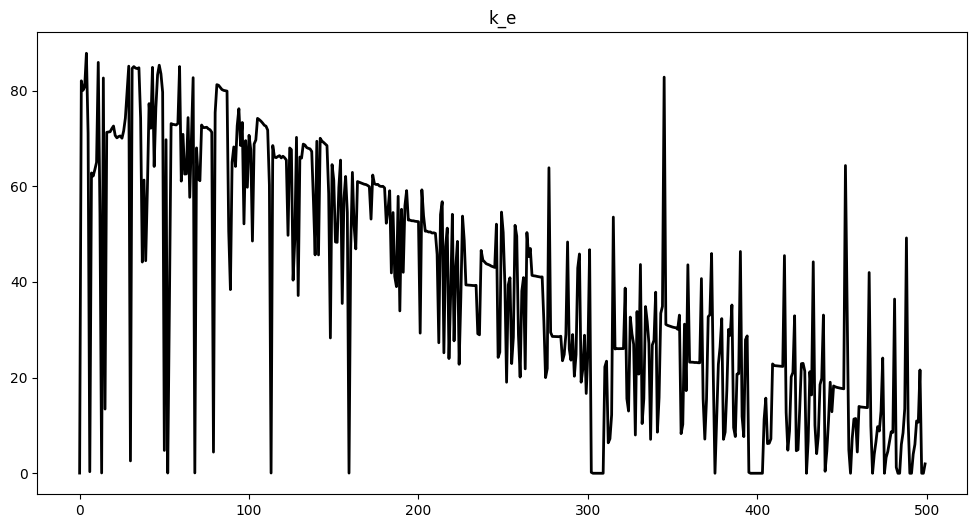

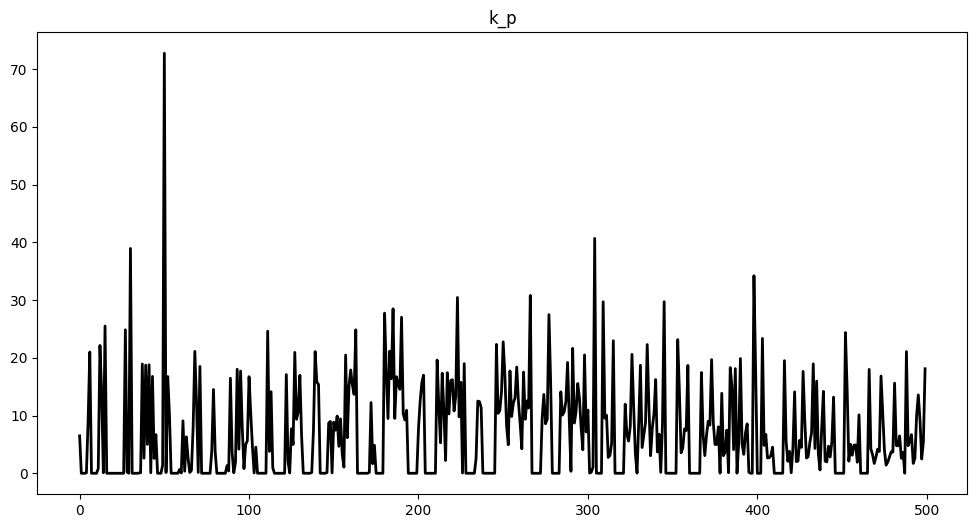

In [482]:
for i in ['a', 'k_i', 'A', 'beta', 'gamma', 'n', 'k_e', 'k_p']:
    plt.figure(figsize=(12, 6))
    plt.plot(params_df[i], color = 'k', linewidth=2)
    plt.title(i)
    plt.show()

In [ ]:
def reconstruct_F_from_disp_by_windows(displacement, params_dict, dt=0.1, z0=0.0, carry_state=True):
    """
    displacement: 전체 변위 시계열 (1D array-like)
    params_dict: {(start_idx, end_idx): {'a','k_i','A','beta','gamma','n', ...}}
                 mode='disp'로 추정된 파라미터 사전 (fit_by_chunks 결과)
    dt: 샘플 간격
    z0: 전체 구간 시작 시점의 히스테리시스 초기값
    carry_state: 윈도우 경계에서 z 상태를 다음 윈도우로 넘길지 여부

    반환: (F_rec, z_rec)  길이 len(displacement)의 힘/히스테리시스 시계열
    """
    u = np.asarray(displacement, dtype=float)
    N = len(u)
    F_rec = np.full(N, np.nan, dtype=float)
    z_rec = np.full(N, np.nan, dtype=float)

    cur_z0 = float(z0)

    def _sim_disp_chunk(u_chunk, p, dt, z0):
        a = p['a']; k = p['k_i']; A = p['A']; beta = p['beta']; gamma = p['gamma']; n = p['n']
        # 점성(c), 오프셋(F0) 패치를 쓰는 환경이라면 자동 대응
        c = p.get('c', 0.0); F0 = p.get('F0', 0.0)
        try:
            # 패치 버전이 있다면 이 시그니처가 있고, 없으면 TypeError로 내려감
            return simulate_disp_control(u_chunk, a, k, A, beta, gamma, n, dt=dt, z0=z0, c=c, F0=F0)
        except TypeError:
            # 기본(패치 없는) 버전
            return simulate_disp_control(u_chunk, a, k, A, beta, gamma, n, dt=dt, z0=z0)

    # 윈도우 순서대로 처리
    for (s, e) in sorted(params_dict.keys(), key=lambda x: x[0]):
        p = params_dict[(s, e)]
        u_chunk = u[s:e]
        if len(u_chunk) == 0:
            continue

        F_chunk, z_chunk = _sim_disp_chunk(u_chunk, p, dt, cur_z0)

        F_rec[s:e] = F_chunk
        z_rec[s:e] = z_chunk

        if carry_state:
            cur_z0 = float(z_chunk[-1])
        else:
            cur_z0 = 0.0

    return F_rec, z_rec

In [326]:
u_all = df['UTM Disp'].values
F_true = df['UTM Force'].values

F_hat, z_hat = reconstruct_F_from_disp_by_windows(
    u_all, params_dict2, dt=0.1, z0=0.0, carry_state=False
)


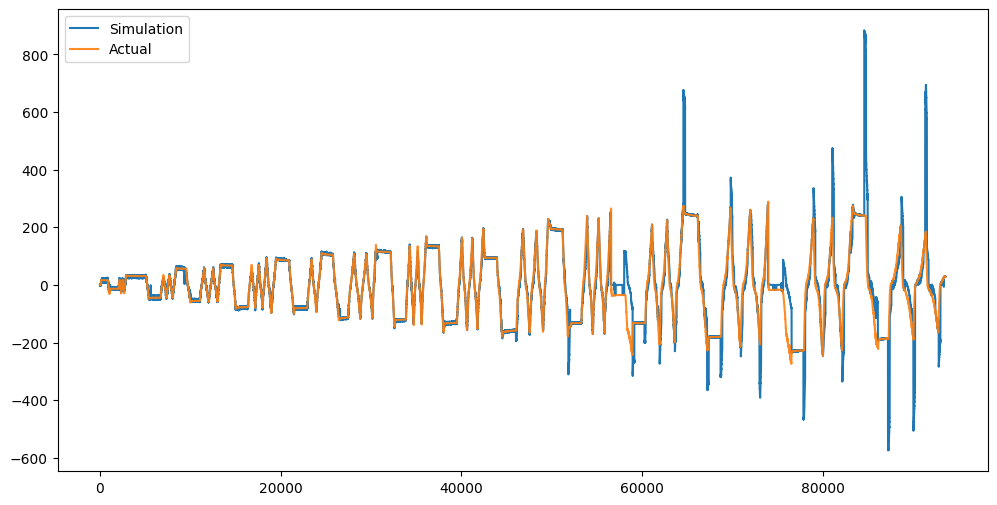

In [336]:
plt.figure(figsize=(12, 6))
plt.plot(F_hat, label = 'Simulation')
plt.plot(F_true, alpha = 0.9, label = 'Actual')
plt.legend()
plt.show()

----
# PINN 구현

In [403]:
import torch
import torch.nn as nn
import torch.optim as optim

In [415]:
def finite_diff_uniform(u: np.ndarray, dt: float) -> np.ndarray:
    u = np.asarray(u, dtype=float).reshape(-1)
    du = np.empty_like(u)
    du[1:-1] = (u[2:] - u[:-2]) / (2.0 * dt)
    du[0]    = (u[1] - u[0]) / dt
    du[-1]   = (u[-1] - u[-2]) / dt
    return du

In [422]:
class BoucWenPINN(nn.Module):
    """
    Input: (t, u) -> Output: z(t,u)
    Force: F = a k u + (1-a)k z + c u_dot + F0
    Residual: dz/dt - A*(u_dot - beta*|u_dot|*|z|^(n-1)z - gamma*u_dot*|z|^n)
    """
    def __init__(self, hidden=128, depth=4, act='silu',
                 a0=0.4, k0=10.0, A0=0.8, beta0=0.2, gamma0=-0.1, n0=2.0, c0=0.0, F00=0.0):
        super().__init__()
        acts = {'tanh': nn.Tanh(), 'relu': nn.ReLU(), 'gelu': nn.GELU(), 'silu': nn.SiLU()}
        self.act = acts.get(act, nn.SiLU())

        layers = [nn.Linear(2, hidden), self.act]
        for _ in range(depth-1):
            layers += [nn.Linear(hidden, hidden), self.act]
        layers += [nn.Linear(hidden, 1)]
        self.net = nn.Sequential(*layers)

        # parameterization with constraints
        self.softplus = nn.Softplus()
        self.eps = 1e-12

        self.a_raw = nn.Parameter(torch.tensor(np.log(a0/(1-a0)), dtype=torch.float32))                 # (0,1)
        self.k_raw = nn.Parameter(torch.tensor(np.log(np.exp(k0)-1), dtype=torch.float32))              # >0
        self.A_raw = nn.Parameter(torch.tensor(np.log(np.exp(A0)-1), dtype=torch.float32))              # >0
        self.n_raw = nn.Parameter(torch.tensor(np.log(np.exp(max(n0-1.0,1e-6))-1), dtype=torch.float32))# >=1
        self.c_raw = nn.Parameter(torch.tensor(np.log(np.exp(max(c0,0.0))-1), dtype=torch.float32))     # >=0

        self.beta  = nn.Parameter(torch.tensor(beta0, dtype=torch.float32))
        self.gamma = nn.Parameter(torch.tensor(gamma0, dtype=torch.float32))
        self.F0    = nn.Parameter(torch.tensor(F00, dtype=torch.float32))

        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)

    @property
    def a(self): return torch.sigmoid(self.a_raw)
    @property
    def k(self): return self.softplus(self.k_raw) + self.eps
    @property
    def A(self): return self.softplus(self.A_raw) + self.eps
    @property
    def n(self): return 1.0 + self.softplus(self.n_raw)
    @property
    def c(self): return self.softplus(self.c_raw)

    def forward(self, t, u):
        x = torch.cat([t, u], dim=1)
        return self.net(x)  # z

    def force_from_phys(self, u, u_dot, z):
        return self.a*self.k*u + (1.0-self.a)*self.k*z + self.c*u_dot + self.F0

    def bw_residual(self, t, u, u_dot, z):
        dz_dt_part, dz_du = torch.autograd.grad(
            z, [t, u], grad_outputs=torch.ones_like(z),
            create_graph=True, retain_graph=True
        )
        dz_dt = dz_dt_part + dz_du * u_dot
        abs_z = torch.abs(z)
        z_pow_n_minus_1_z = torch.where(abs_z>1e-12, z*(abs_z**(self.n-1.0)), torch.zeros_like(z))
        z_pow_n = abs_z**self.n
        rhs = self.A*(u_dot - self.beta*torch.abs(u_dot)*z_pow_n_minus_1_z - self.gamma*u_dot*z_pow_n)
        return dz_dt - rhs

    def current_params(self):
        return { 'a': float(self.a.detach().cpu()),
                 'k': float(self.k.detach().cpu()),
                 'A': float(self.A.detach().cpu()),
                 'beta': float(self.beta.detach().cpu()),
                 'gamma': float(self.gamma.detach().cpu()),
                 'n': float(self.n.detach().cpu()),
                 'c': float(self.c.detach().cpu()),
                 'F0': float(self.F0.detach().cpu()) }

In [423]:
def train_pinn(t_np, u_np, F_np, dt=0.1, hidden=128, depth=4, act='silu',
               w_data=1.0, w_phys=1.0, w_ic=0.0, z0=0.0,
               epochs=4000, lr=1e-3, device=None, verbose_every=500):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    t_np = np.asarray(t_np).reshape(-1); u_np = np.asarray(u_np).reshape(-1); F_np = np.asarray(F_np).reshape(-1)
    assert len(t_np)==len(u_np)==len(F_np)
    u_dot_np = finite_diff_uniform(u_np, dt)

    t = torch.tensor(t_np, dtype=torch.float32, device=device).view(-1,1).requires_grad_(True)
    u = torch.tensor(u_np, dtype=torch.float32, device=device).view(-1,1).requires_grad_(True)
    u_dot = torch.tensor(u_dot_np, dtype=torch.float32, device=device).view(-1,1)
    F = torch.tensor(F_np, dtype=torch.float32, device=device).view(-1,1)

    model = BoucWenPINN(hidden=hidden, depth=depth, act=act).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()

    for ep in tqdm(range(1, epochs+1)):
        opt.zero_grad()
        z = model(t, u)
        F_hat = model.force_from_phys(u, u_dot, z)
        r = model.bw_residual(t, u, u_dot, z)

        data_loss = mse(F_hat, F)
        phys_loss = torch.mean(r**2)
        ic_loss = (z[0] - z0)**2 if w_ic>0 else torch.tensor(0.0, device=device)

        loss = w_data*data_loss + w_phys*phys_loss + w_ic*ic_loss
        loss.backward(); opt.step()

        if verbose_every and ep % verbose_every == 0:
            params = model.current_params()
            print(f"[{ep:5d}] loss={loss.item():.3e}  data={data_loss.item():.3e}  phys={phys_loss.item():.3e}  "
                  f"a={params['a']:.3f} k={params['k']:.1f} A={params['A']:.3f} "
                  f"beta={params['beta']:.3f} gamma={params['gamma']:.3f} "
                  f"n={params['n']:.2f} c={params['c']:.3f} F0={params['F0']:.3f}")
    return model

In [459]:
def eval_and_plot(model, t_np, u_np, F_np, dt=0.1, title='PINN Bouc–Wen'):
    device = next(model.parameters()).device
    t_t = torch.tensor(t_np, dtype=torch.float32, device=device).view(-1,1).requires_grad_(True)
    u_t = torch.tensor(u_np, dtype=torch.float32, device=device).view(-1,1).requires_grad_(True)
    u_dot_np = finite_diff_uniform(u_np, dt)
    u_dot_t = torch.tensor(u_dot_np, dtype=torch.float32, device=device).view(-1,1)

    with torch.no_grad():
        z_t = model(t_t, u_t)
        F_hat_t = model.force_from_phys(u_t, u_dot_t, z_t)

    z = z_t.cpu().numpy().reshape(-1)
    F_hat = F_hat_t.cpu().numpy().reshape(-1)
    F = np.asarray(F_np).reshape(-1)
    u = np.asarray(u_np).reshape(-1)
    t = np.asarray(t_np).reshape(-1)

    err = F_hat - F
    mae = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    r2 = float(1.0 - np.sum(err**2)/np.sum((F - F.mean())**2))

    print(f"Eval — MAE={mae:.6f}, RMSE={rmse:.6f}, R²={r2:.4f}")
    print("Learned params:", model.current_params())

    # plots
    plt.figure(figsize=(12,7))
    plt.plot(t, F, label='F true', lw=2)
    plt.plot(t, F_hat, '--', label='F pred', lw=2, ls = '-')
    plt.xlabel(''); plt.ylabel(''); plt.grid(True, alpha=0.3); plt.legend(fontsize = 15); plt.tight_layout(); plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(u, F, lw=1, alpha=0.7, label='True')
    plt.plot(u, F_hat, '--', lw=1.2, label='Pred')
    plt.xlabel('Displacement'); plt.ylabel('Force'); plt.title('Hysteresis'); plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(12,3.5))
    plt.plot(t, z, lw=1, label='z')
    plt.xlabel('t (s)'); plt.ylabel('z'); plt.title('Hysteresis state z(t)'); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

    return dict(mae=mae, rmse=rmse, r2=r2, F_hat=F_hat, z=z)

In [438]:
u_all = df['UTM Disp'].values.astype(float)   # x
F_all = df['UTM Force'].values.astype(float)  # y
dt = 0.1
t_all = np.arange(len(u_all)) * dt

In [445]:
N = len(u_all)
split = int(0.7 * N)

In [446]:
t_tr, u_tr, F_tr = t_all[:split], u_all[:split], F_all[:split]
t_te, u_te, F_te = t_all[split:], u_all[split:], F_all[split:]


In [447]:
model = train_pinn(
    t_tr, u_tr, F_tr, dt=dt,
    hidden=128, depth=4, act='relu',
    w_data=2.0, w_phys=1.0, w_ic=0.0, z0=0.0,
    epochs=3000, lr=1e-3, verbose_every=500
)

  0%|          | 0/3000 [00:00<?, ?it/s]

 17%|█▋        | 502/3000 [01:46<05:41,  7.31it/s]  

[  500] loss=8.408e+03  data=4.161e+03  phys=8.513e+01  a=0.405 k=10.0 A=0.794 beta=0.189 gamma=-0.088 n=1.99 c=0.000 F0=0.001


 33%|███▎      | 1002/3000 [02:58<04:35,  7.24it/s]

[ 1000] loss=5.328e+03  data=2.625e+03  phys=7.912e+01  a=0.404 k=10.0 A=0.794 beta=0.188 gamma=-0.088 n=1.99 c=0.000 F0=0.007


 50%|█████     | 1500/3000 [04:21<05:06,  4.89it/s]

[ 1500] loss=5.159e+03  data=2.515e+03  phys=1.291e+02  a=0.406 k=10.0 A=0.793 beta=0.187 gamma=-0.087 n=1.99 c=0.000 F0=0.017


 67%|██████▋   | 2000/3000 [06:15<04:14,  3.94it/s]

[ 2000] loss=5.156e+03  data=2.517e+03  phys=1.218e+02  a=0.406 k=10.0 A=0.792 beta=0.185 gamma=-0.086 n=1.99 c=0.000 F0=0.026


 83%|████████▎ | 2500/3000 [08:08<01:51,  4.48it/s]

[ 2500] loss=5.142e+03  data=2.509e+03  phys=1.244e+02  a=0.405 k=10.0 A=0.791 beta=0.184 gamma=-0.085 n=1.99 c=0.000 F0=0.037


100%|██████████| 3000/3000 [09:54<00:00,  5.05it/s]

[ 3000] loss=5.139e+03  data=2.512e+03  phys=1.152e+02  a=0.425 k=9.9 A=0.785 beta=0.171 gamma=-0.073 n=1.99 c=0.000 F0=0.046


Eval — MAE=36.299793, RMSE=50.118717, R²=0.7384
Learned params: {'a': 0.4246121048927307, 'k': 9.94282341003418, 'A': 0.7851210832595825, 'beta': 0.17074041068553925, 'gamma': -0.07334915548563004, 'n': 1.98557710647583, 'c': 0.0, 'F0': 0.046247415244579315}


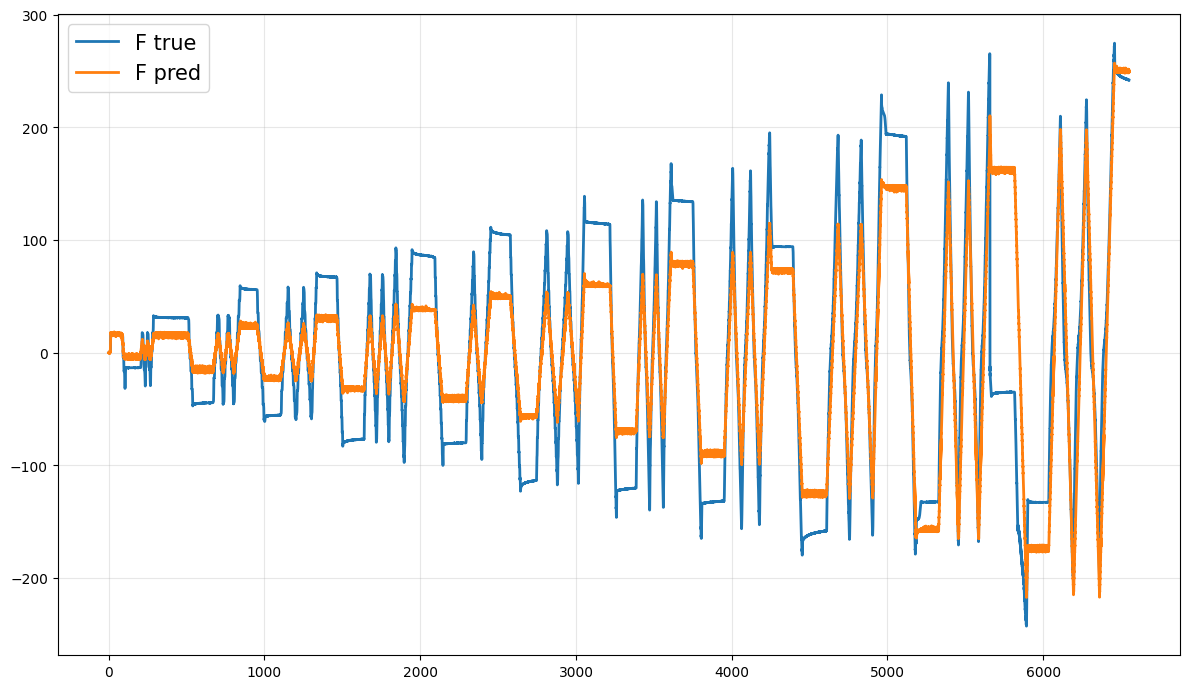

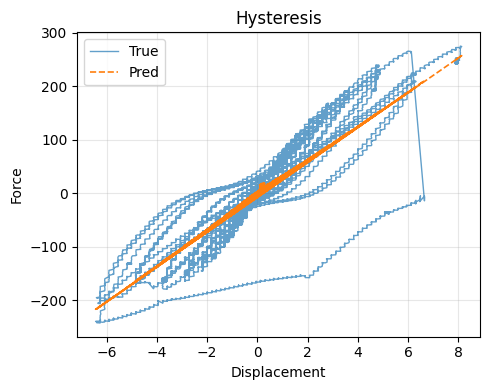

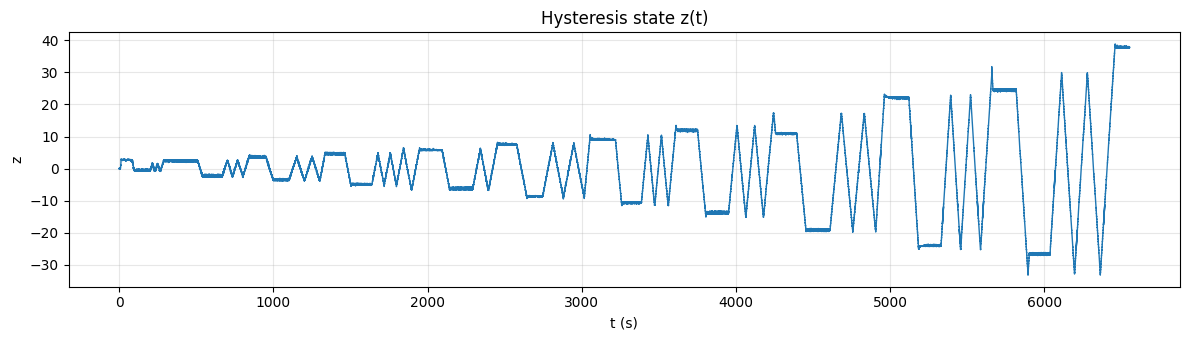

In [460]:
res_tr = eval_and_plot(model, t_tr, u_tr, F_tr, dt=dt, title='PINN (Train)')


Eval — MAE=130.650362, RMSE=162.271272, R²=-0.3623
Learned params: {'a': 0.4246121048927307, 'k': 9.94282341003418, 'A': 0.7851210832595825, 'beta': 0.17074041068553925, 'gamma': -0.07334915548563004, 'n': 1.98557710647583, 'c': 0.0, 'F0': 0.046247415244579315}


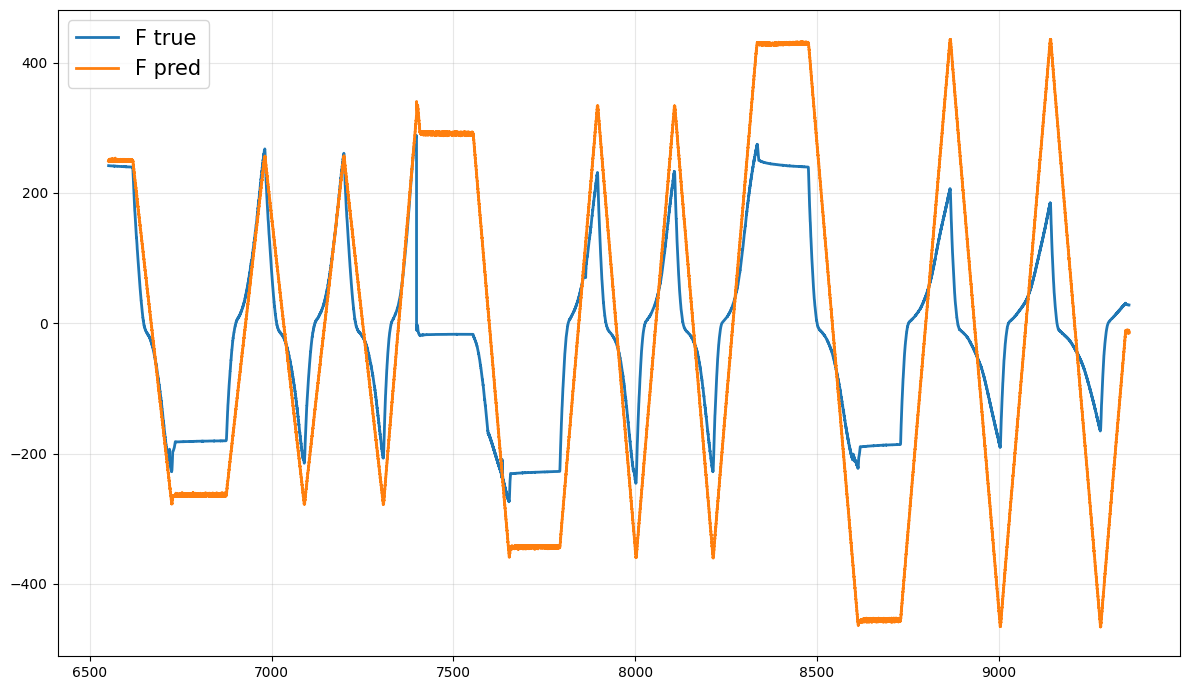

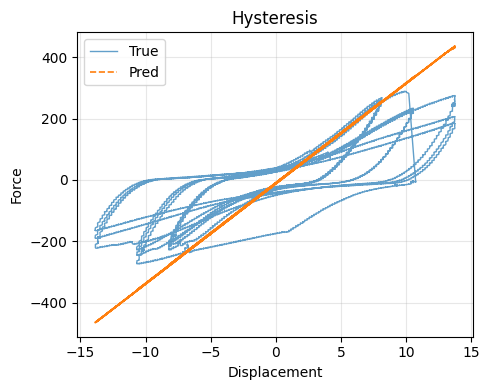

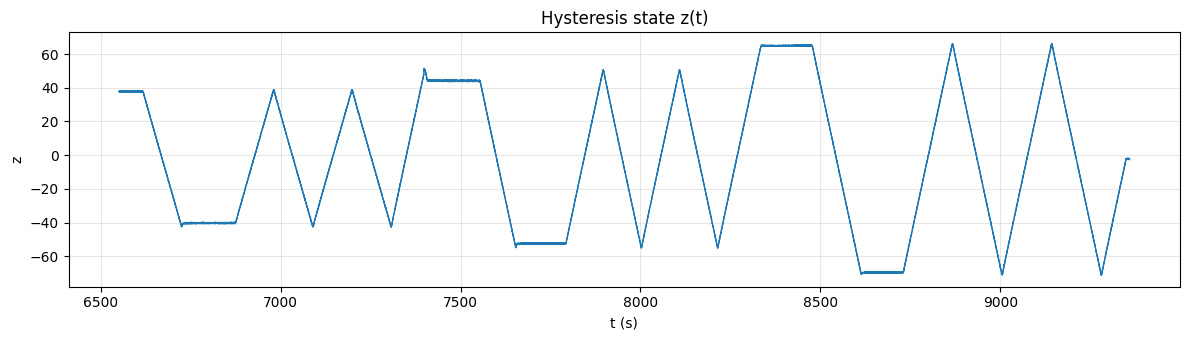

In [461]:
res_te = eval_and_plot(model, t_te, u_te, F_te, dt=dt, title='PINN (Test)')


array([248.60962 , 248.87206 , 248.60936 , ..., -11.515954, -13.355069,
       -14.406603], dtype=float32)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

In [467]:
mean_absolute_error(F_te, res_te['F_hat'])

np.float64(130.65036243629288)

In [466]:
r2_score(F_te, res_te['F_hat'])

-0.36229136290906827